# Modelado v1.0
---

## Modelos y técnicas a emplear

En este notebook, vamos a partir del dataset ligeramente modificado durante la EDA, y en base al conocimiento que nos ha aportado esta, vamos a preprocesar los datos para optimizar el funcionamiento de los modelos de clasificación binaria. Los modelos a probar son :

- Regresion logística
- Árbol de decisión
- XGBoost
- Red Neuronal

En concreto, para el entrenamiento de los modelos, se empleará validación cruzada stratificada utilizando 5 folds, como consecuencia de el pequeño dataset que se va a utilizar, y las pocas instancias de la clase de abandono presentes, además de tratar de evaluar fielmente los datos dependiendo menos de la distribución aleatoria de las instancias que tiene lugar al hacer el split del dataset.. 

Además, se va a evaluar el funcionamiento de los modelos aplicando muestreo SMOTE a los datos de cada fold para compensar el desbalance de clases. Por lo tanto, se evaluará si dan un mejor rendimiento los modelos aplicando esta técnica o no. 

## Diseño del flujo de preprocesamiento y modelado mediante `ColumnTransformer` y `Pipeline`

Para desarrollar el código de esta sección, se ha buscado utilizar una estructura que facilite la reutilización del flujo y la seguridad ante fugas de datos durante el entrenamiento.  Para ello, se utilizan dos herramientas clave de `scikit-learn`: `ColumnTransformer` y `Pipeline`.

### ¿Por qué utilizar `ColumnTransformer`?

`ColumnTransformer` permite aplicar diferentes transformaciones a distintos subconjuntos  de columnas, permitiendonos definir claramente y de forma reutilizable las tareas de preprocesado a realizar sobre los datos. En nuestro caso, se utiliza para:

- Aplicar un **escalado estándar** (`StandardScaler`) a las variables numéricas (notas y número de entregas), lo cual es fundamental para modelos sensibles a la escala como la regresión logística o las redes neuronales.
- Dejar **sin transformar** las variables binarias (entregas realizadas o no), ya que su interpretación directa como 0/1 es válida y no necesita normalización.

Este enfoque evita tener que realizar transformaciones manuales separadas y asegura que cada tipo de dato reciba el tratamiento adecuado dentro de un único objeto reutilizable.

### ¿Por qué usar `Pipeline`?

El objeto `Pipeline` permite encapsular el flujo completo de entrenamiento en una única estructura compuesta por varios pasos encadenados:

1. Transformaciones (`preproc`) mediante el `ColumnTransformer`.
2. (Opcional) Técnicas de balanceo como `SMOTE`.
3. Entrenamiento del modelo (regresión logística, árbol, XGBoost o red neuronal) y evaluación.

Además, `Pipeline` garantiza que cada etapa del preprocesamiento y modelado se ejecute de forma segura durante la validación cruzada. Por ejemplo, en cada fold, se asegura de que:

- Las transformaciones se ajusten **solo sobre los datos de entrenamiento**.
- El muestreo como SMOTE no vea los datos de validación.
- La evaluación se haga únicamente con datos no vistos, evitando fugas de información.

### Ventajas prácticas

El uso de `Pipeline` y `ColumnTransformer` permite escribir código más limpio, reproducible y mantenible. Además, estos objetos son fácilmente combinables con funciones como `cross_validate`, `GridSearchCV`, o exportables con `joblib`.

Este enfoque también permite construir **plantillas versátiles**, que se pueden reutilizar con distintos modelos o datasets con mínimos ajustes, facilitando el trabajo diario de cualquier científico de datos o ingeniero de machine learning.

En resumen, estas estructuras no solo mejoran la calidad técnica del flujo de trabajo, sino que también representan una forma moderna y profesional de abordar el desarrollo de sistemas predictivos.

## Configuración del entorno

In [ ]:
# Core
import pandas as pd
import numpy as np

# Modelado
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, roc_auc_score,
                             precision_score, recall_score,
                             make_scorer)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

# Desbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from tensorflow import keras
from tensorflow.keras.optimizers import Adam


#----------Rutas de los datos----------
DATA_PATH = '/home/carlos/Documentos/TFG/spark-workspace/data/datasets/dataset_1.0.parquet'


## Carga del dataset limpio

In [5]:
df = pd.read_parquet(DATA_PATH)  # o la ruta que uses

# Separar X / y
X = df.drop(columns=["userid", "abandona"])
y = df["abandona"]

# Display schema of both X and y
# display(X.info(), y.describe())


## Preprocesamiento de los datos

En esta celda se define un `ColumnTransformer` que aplica diferentes transformaciones a las columnas del dataset:

- Los valores nulos, los cuales pueden aparecer en las columnas de notas, son imputados a 0, y los negativos igual.

- A las variables **numéricas** (notas y `num_entregas`), se les aplica un **escalado estándar** (`StandardScaler`), que transforma sus valores para que tengan media 0 y desviación estándar 1. Esto es importante para modelos como la regresión logística o las redes neuronales, ya que son sensibles a la magnitud de los datos y funcionan mejor cuando todas las variables están en escalas similares. Sin embargo, no afectará a el entrenamiento del árbol de decisión, ni al de XgBoost
  
- Las variables **binarias** (entregas: 0 o 1) se dejan sin modificar (`passthrough`), ya que no necesitan escalado y su interpretación es directa.



In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Columnas numéricas y binarias
num_cols  = [c for c in X.columns if "(nota)" in c or c == "num_entregas"]
bin_cols  = [c for c in X.columns if c not in num_cols]

# Pipeline para columnas numéricas: imputar NaN → 0, luego -1 → 0, luego escalar
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)),
    ("neg_to_zero", FunctionTransformer(lambda X: np.where(X == -1, 0, X))),
    ("scaler", StandardScaler())
])

# ColumnTransformer combinado
preproc = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("bin", "passthrough", bin_cols)
    ]
)


## Definición de modelos de clasificación

En esta celda se definen los cuatro modelos que se utilizarán para predecir el abandono de los estudiantes. Cada modelo se ajusta mediante una configuración inicial de hiperparámetros y está preparado para integrarse en un pipeline de entrenamiento y validación.

- **Regresión logística** (`LogReg`): modelo lineal clásico para clasificación binaria. Se le aplica `class_weight="balanced"` para compensar el desbalance entre clases, haciendo que penalice más los errores en la clase minoritaria (abandono).

- **Árbol de decisión** (`DecTree`): clasificador basado en reglas que particiona el espacio de decisiones. También se incluye `class_weight="balanced"` y se fija una semilla (`random_state=42`) para obtener resultados reproducibles. En esta primera fase no se ajusta su profundidad; se deja abierta la posibilidad de afinarla después.

- **XGBoost** (`XGBoost`): modelo basado en árboles de gradiente. Se utilizan parámetros conservadores para evitar sobreajuste: `max_depth=4`, `learning_rate=0.05`, `subsample=0.8`, y `colsample_bytree=0.8`. El parámetro `scale_pos_weight` se ajusta automáticamente para compensar el desbalance entre clases.

- **Red neuronal con Keras** (`NeuralNet`): se define una red neuronal secuencial con dos capas densas intermedias (64 y 32 neuronas) y una capa de salida con activación sigmoide. Se añade un `Dropout` intermedio para reducir el riesgo de sobreajuste. Se entrena durante 60 épocas con tamaño de lote 16, y también se compensa el desbalance de clases mediante `class_weight`.

Todos estos modelos serán evaluados con validación cruzada estratificada, primero sin aplicar técnicas de balanceo de datos (como SMOTE) y posteriormente comparando con ellas para analizar su impacto.


In [7]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# build_model recibe meta‐info de scikeras ⇒ no usamos globals
def build_model(meta, units=64, dr=0.3):
    n_features = meta["n_features_in_"]       # scikeras se lo pasa
    model = Sequential([
        Dense(units, activation="relu", input_shape=(n_features,)),
        Dropout(dr),
        Dense(units // 2, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(1e-3),   
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

models = {
    "LogReg":   LogisticRegression(max_iter=200, class_weight="balanced"),
    "DecTree":  DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "XGBoost":  XGBClassifier(
                    n_estimators=200, max_depth=4, learning_rate=0.05,
                    subsample=0.8, colsample_bytree=0.8,
                    eval_metric="logloss",
                    scale_pos_weight=y.value_counts()[0] / y.value_counts()[1],
                    random_state=42
                ),
    "NeuralNet": KerasClassifier(
                    model=build_model,          # ① SIN paréntesis
                    epochs=60,
                    batch_size=16,
                    verbose=0,
                    # ② todo lo de .fit con prefijo fit__
                    fit__class_weight={
                        0: 1,
                        1: y.value_counts()[0] / y.value_counts()[1]
                    },
                    random_state=42
                 ),
}


## Función auxiliar de evaluación

Esta celda define la función `evaluate`, que permite entrenar y evaluar un modelo con o sin SMOTE aplicando validación cruzada estratificada. La función construye un pipeline que incluye el preprocesamiento definido anteriormente y, si se indica, un paso intermedio de sobremuestreo con `SMOTE`. Luego ejecuta validación cruzada con 5 particiones, evaluando el modelo en cada fold con las métricas `f1`, `roc_auc`, `precision` y `recall`. El resultado es un resumen estadístico (media y desviación típica) para cada métrica, lo que facilita comparar modelos y analizar el impacto de aplicar SMOTE o no.


In [ ]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline as ImbPipeline    # si usas SMOTE
from sklearn.pipeline import Pipeline
from joblib import parallel_backend      # <- NUEVO

# --------------------------- Scorers ----------------------------
scoring = {
    "f1"       : make_scorer(f1_score,       average="binary"),
    "precision": make_scorer(precision_score,average="binary"),
    "recall"   : make_scorer(recall_score,   average="binary"),
    "roc_auc":   lambda est, X, y: roc_auc_score(y, est.predict_proba(X)[:, 1])}

def evaluate(model, use_smote=False, n_jobs=-1):
    """Devuelve media ± std de las métricas, con/sin SMOTE."""
    if use_smote:
        pipe = ImbPipeline([
            ("pre",   preproc),
            ("smote", SMOTE(random_state=42)),
            ("clf",   model)
        ])
    else:
        pipe = Pipeline([
            ("pre", preproc),
            ("clf", model)
        ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    #  ────────────────────────────────────────────
    with parallel_backend("threading"):              
        scores = cross_validate(
            pipe, X, y,
            cv=cv,
            scoring=scoring,
            n_jobs=n_jobs,          
            error_score="raise"
        )
    # ────────────────────────────────────────────────────────────────

    return {m: (scores[f"test_{m}"].mean(),
                scores[f"test_{m}"].std())
            for m in scoring}

## Entrenar y comparar

In [6]:
results_no_smote = {}
results_smote    = {}

for name, model in models.items():
    print(f"→ {name}")
    results_no_smote[name] = evaluate(model, use_smote=False)
    results_smote[name]    = evaluate(model, use_smote=True)


→ LogReg
→ DecTree
→ XGBoost
→ NeuralNet


/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1750357105.536009  209064 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:17

/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(

## Tabla resumen

In [7]:
def to_df(res_dict):
    return (pd.DataFrame(res_dict)
            .stack()
            .unstack(level=1)
            .applymap(lambda x: f"{x[0]:.3f} ± {x[1]:.3f}"))

print("=== Sin SMOTE ===")
display(to_df(results_no_smote))

print("\n=== Con SMOTE ===")
display(to_df(results_smote))


=== Sin SMOTE ===


/tmp/ipykernel_208579/675697531.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: f"{x[0]:.3f} ± {x[1]:.3f}"))


,LogReg,DecTree,XGBoost,NeuralNet
f1,0.494 ± 0.081,0.523 ± 0.110,0.575 ± 0.093,0.508 ± 0.145
precision,0.438 ± 0.119,0.522 ± 0.091,0.596 ± 0.224,0.494 ± 0.172
recall,0.605 ± 0.149,0.538 ± 0.153,0.605 ± 0.076,0.548 ± 0.151
roc_auc,0.836 ± 0.041,0.720 ± 0.071,0.864 ± 0.058,0.822 ± 0.051



=== Con SMOTE ===


/tmp/ipykernel_208579/675697531.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: f"{x[0]:.3f} ± {x[1]:.3f}"))


,LogReg,DecTree,XGBoost,NeuralNet
f1,0.513 ± 0.084,0.433 ± 0.118,0.566 ± 0.106,0.519 ± 0.168
precision,0.492 ± 0.157,0.413 ± 0.140,0.558 ± 0.233,0.624 ± 0.310
recall,0.576 ± 0.105,0.476 ± 0.148,0.633 ± 0.085,0.519 ± 0.157
roc_auc,0.830 ± 0.045,0.679 ± 0.089,0.830 ± 0.074,0.820 ± 0.051


# Visualización de los resultados

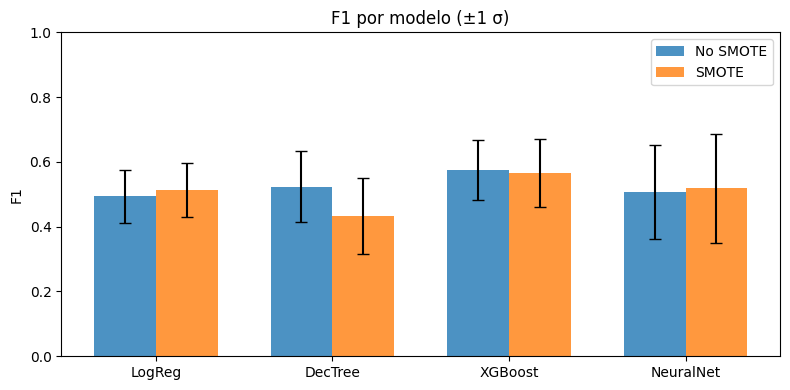

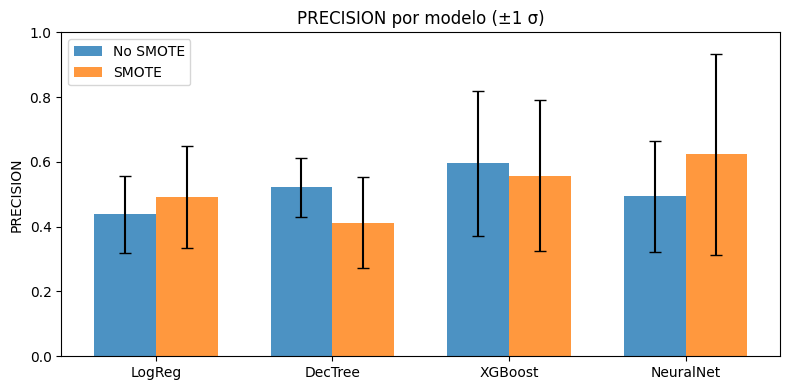

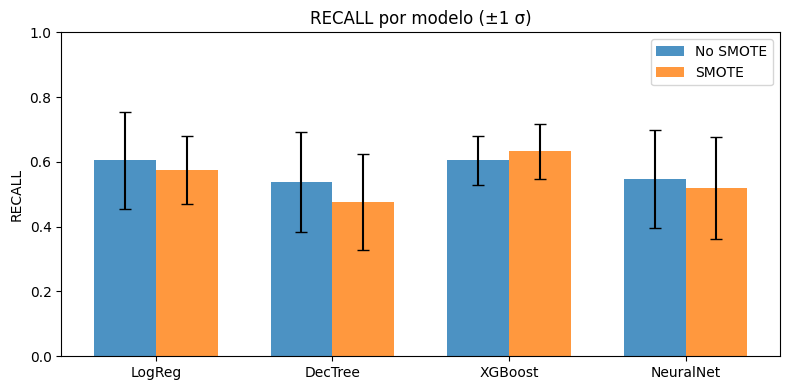

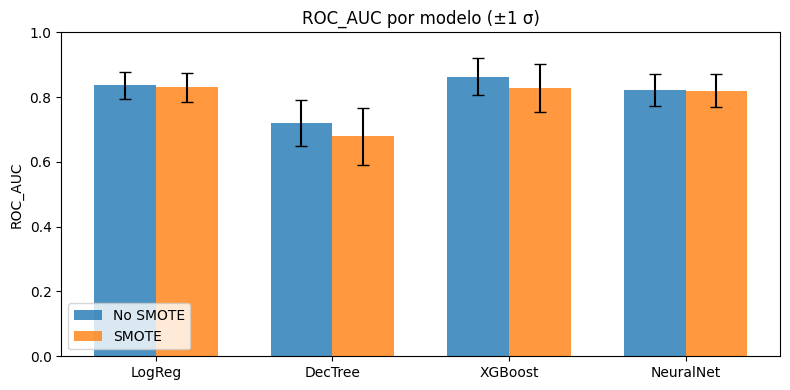

In [8]:

import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Convertir tus dicts {modelo: {metrica: (mean, std)}} a DataFrame largo
def dicts_to_longframe(d, label):
    """Convierte results_* a DataFrame largo con columnas:
       modelo | métrica | mean | std | smote"""
    rows = []
    for modelo, metrics in d.items():
        for m, (mean, std) in metrics.items():
            rows.append((modelo, m, mean, std, label))
    return pd.DataFrame(rows, columns=["model", "metric", "mean", "std", "smote"])

df = pd.concat([
    dicts_to_longframe(results_no_smote, "No SMOTE"),
    dicts_to_longframe(results_smote,  "SMOTE")
])

# --- 2) Gráfico separado por métrica ---------------------------------
metrics_order = ["f1", "precision", "recall", "roc_auc"]

for met in metrics_order:
    plt.figure(figsize=(8,4))
    sub = df[df.metric == met]
    # Orden fijo de modelos para coherencia visual
    order = ["LogReg", "DecTree", "XGBoost", "NeuralNet"]
    # Barras agrupadas: una para No SMOTE y otra para SMOTE
    width = 0.35
    x = range(len(order))
    for i, sm_label in enumerate(["No SMOTE", "SMOTE"]):
        sm_data = sub[sub.smote == sm_label].set_index("model").loc[order]
        plt.bar([p + i*width for p in x],
                sm_data["mean"],
                yerr=sm_data["std"],
                width=width,
                label=sm_label,
                alpha=0.8,
                capsize=4)
    plt.xticks([p + width/2 for p in x], order)
    plt.ylabel(met.upper())
    plt.title(f"{met.upper()} por modelo (±1 σ)")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Discusión  de resultados

Tras entrenar y validar los cuatro algoritmos (Logistic Regression, Decision Tree, XGBoost y Red Neuronal) tanto con los datos originales como con sobremuestreo SMOTE, las evidencias apuntan a:

1. **XGBoost sin SMOTE** alcanza el **mayor AUC (0 .864) y el mejor F1 (0 .575)**, lo que indica la capacidad de discriminar correctamente estudiantes con mayor balance entre falsos positivos y falsos negativos.  
2. **XGBoost con SMOTE** aumenta el *recall* hasta 0 .633: el sistema “atrapa” más abandonos, pero su precisión y AUC caen levemente. Es la alternativa idónea cuando el coste de no detectar un abandono es muy alto.  
3. **La red neuronal con SMOTE** ofrece la **mayor precisión** (0 .624). Elegible cuando los falsos positivos sean especialmente caros.  
4. **El árbol de decisión** presenta el rendimiento más discreto y reacciona mal a SMOTE, por lo que se descarta como candidato principal.  

**XGBoost sin SMOTE** se destaca como el que ofrece un mejor rendimiento global. Para escenarios donde la prioridad absoluta sea maximizar la detección —aceptando más avisos erróneos— se recomienda la variante con SMOTE.

Las gráficas anteriores refuerzan estas conclusiones:  
* el bloque XGBoost domina en casi todas las métricas, y la diferencia entre las barras No SMOTE y SMOTE ilustra claramente el compromiso \[↑recall vs ↓precisión/AUC\].*



## Curva PR para ver tradeoff de precission y recall al mover el umbral

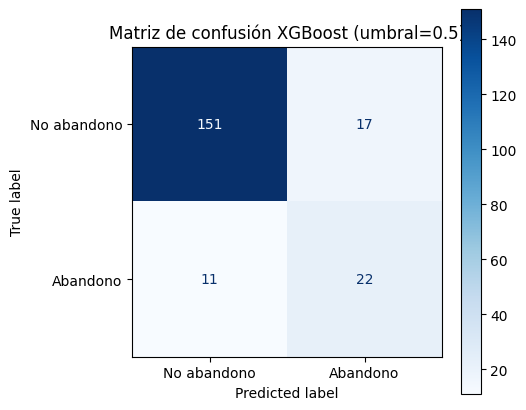

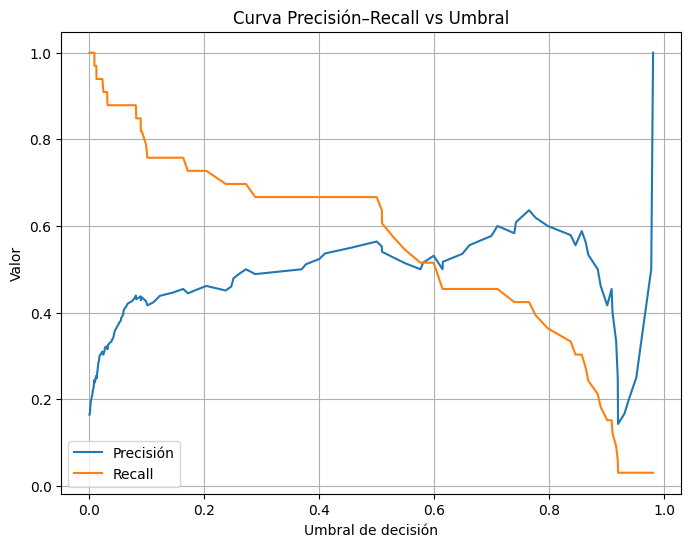

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (precision_recall_curve,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# 1) Reentrena XGBoost con CV y obtiene predicciones probabilísticas
xgb_model = models["XGBoost"]
y_scores = cross_val_predict(
    xgb_model, X, y, cv=5,
    method="predict_proba", n_jobs=-1
)[:, 1]



# 3) Ahora, matriz de confusión a umbral=0.5
y_pred_05 = (y_scores >= 0.5).astype(int)
cm = confusion_matrix(y, y_pred_05, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["No abandono","Abandono"])

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap="Blues", ax=ax)
ax.set_title("Matriz de confusión XGBoost (umbral=0.5)")
plt.show()


# 2) Traza la curva Precision–Recall
precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label="Precisión")
plt.plot(thresholds, recalls[:-1],    label="Recall")
plt.xlabel("Umbral de decisión")
plt.ylabel("Valor")
plt.title("Curva Precisión–Recall vs Umbral")
plt.legend()
plt.grid(True)
